In [1]:
 
import numpy as np 
import pandas as pd 

import numpy as np 
from tqdm import tqdm
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_img_dir = './ISIC_2020_Training_JPEG/train/'
test_img_dir = './ISIC_2020_Test_JPEG\ISIC_2020_Test_Input/'
train = pd.read_csv('./ISIC_2020_Training_GroundTruth.csv')
test = pd.read_csv('./sample_submission.csv')

In [3]:
print(tf.__version__)

2.9.1


In [4]:
train.target.value_counts()

0    32542
1      584
Name: target, dtype: int64

In [5]:
benign = train[train['target']==0].sample(2500)
malignant = train[train['target']==1]
train=pd.concat([benign,malignant])
train=train.reset_index()

In [6]:
malignant.value_counts()

image_name    patient_id  sex     age_approx  anatom_site_general_challenge  diagnosis  benign_malignant  target
ISIC_0149568  IP_0962375  female  55.0        upper extremity                melanoma   malignant         1         1
ISIC_6931277  IP_9772004  male    90.0        torso                          melanoma   malignant         1         1
ISIC_6809586  IP_1173567  male    70.0        upper extremity                melanoma   malignant         1         1
ISIC_6829008  IP_9635781  female  50.0        lower extremity                melanoma   malignant         1         1
ISIC_6841294  IP_2352610  male    65.0        torso                          melanoma   malignant         1         1
                                                                                                                   ..
ISIC_3391427  IP_4956722  male    60.0        torso                          melanoma   malignant         1         1
ISIC_3394520  IP_1023029  female  15.0        torso          

In [7]:
benign.value_counts()

image_name    patient_id  sex     age_approx  anatom_site_general_challenge  diagnosis  benign_malignant  target
ISIC_0080512  IP_1870306  male    75.0        torso                          unknown    benign            0         1
ISIC_6615000  IP_9544996  female  35.0        torso                          unknown    benign            0         1
ISIC_6580094  IP_1251610  male    35.0        torso                          nevus      benign            0         1
ISIC_6587310  IP_1969685  male    50.0        torso                          unknown    benign            0         1
ISIC_6588756  IP_1730314  male    30.0        lower extremity                unknown    benign            0         1
                                                                                                                   ..
ISIC_3350519  IP_1294580  female  55.0        lower extremity                unknown    benign            0         1
ISIC_3359829  IP_5922049  male    25.0        torso          

In [45]:
SIZE=224
train_set = []
for image_name in train.image_name:
    train_set.append(tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(path = (train_img_dir + image_name + ".jpg"), color_mode = "rgb", target_size = (SIZE,SIZE)), dtype="float32"))

In [46]:
train["img"] = train_set
test["path"] = [(test_img_dir + image_name + ".jpg") for image_name in test.image_name]

In [47]:
train.head()

,index,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,img
0,31079,ISIC_9391954,IP_7887363,male,60.0,head/neck,unknown,benign,0,"[[[138.0, 68.0, 66.0], [137.0, 67.0, 59.0], [1..."
1,31439,ISIC_9498714,IP_1994743,male,50.0,torso,nevus,benign,0,"[[[198.0, 129.0, 147.0], [199.0, 130.0, 148.0]..."
2,20164,ISIC_6127495,IP_8296470,female,55.0,head/neck,unknown,benign,0,"[[[191.0, 186.0, 206.0], [128.0, 95.0, 104.0],..."
3,4126,ISIC_1346562,IP_4978372,male,60.0,lower extremity,unknown,benign,0,"[[[142.0, 96.0, 109.0], [148.0, 102.0, 113.0],..."
4,3890,ISIC_1270307,IP_7606510,female,45.0,torso,unknown,benign,0,"[[[192.0, 139.0, 155.0], [190.0, 142.0, 156.0]..."


In [48]:
train.shape

(3084, 10)

In [49]:
x_train, x_cross_validation, y_train, y_cross_validation = train_test_split(train.img, train.target, test_size=0.2, shuffle = True, random_state=42)

In [50]:
x_train.shape

(2467,)

In [51]:
# scale the pixels between 0 and 1
x_train /= 255
x_cross_validation /= 255
# redefine dtypes
y_train = np.array(y_train, dtype = "float32")
y_cross_validation = np.array(y_cross_validation, dtype = "float32")
x_train = np.array([np.array(val) for val in x_train])
x_cross_validation = np.array([np.array(val) for val in x_cross_validation])

In [52]:
batch_size = 64
num_classes = 2
epochs = 5

In [53]:
# focal loss
import keras.backend as K
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [54]:
# we will use Adam optimizer
opt = Adam(lr=1e-3)

#total number of iterations is always equal to the total number of training samples divided by the batch_size.
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=x_cross_validation.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 48 and 9


C:\Users\vamsh\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [55]:
# Pixel Normalization and Image Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

# no need to create augmentation images for validation data, only rescaling the pixels
val_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_cross_validation, y_cross_validation, batch_size=32)

In [56]:

base_model = keras.applications.resnet50.ResNet50(input_shape=(SIZE,SIZE,3),include_top=False,weights='imagenet')

In [57]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [58]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [59]:
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(SIZE,SIZE,3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.003))(x)
x = layers.Dropout(0.35)(x)
x = layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.003))(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

In [60]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [61]:
model.compile(loss=focal_loss(), metrics=["accuracy"],optimizer=opt)

In [62]:
out = train["target"]

In [63]:



# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced', np.unique(out), out) 
# classWeight = dict(enumerate(classWeight))

In [64]:
from keras.callbacks import EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1, verbose=1)


history = model.fit_generator(train_generator, steps_per_epoch=nb_train_steps, epochs=epochs,callbacks=[es],
                              validation_data=val_generator, validation_steps=nb_val_steps, 
                              verbose=1)

In [65]:
history = model.fit(train_generator, epochs=epochs,callbacks=[es], validation_data=val_generator,  verbose=1)

Epoch 1/5
78/78 [==============================] - 194s 2s/step - loss: 0.3800 - accuracy: 0.7981 - val_loss: 0.1556 - val_accuracy: 0.8266
Epoch 2/5
78/78 [==============================] - 189s 2s/step - loss: 0.1278 - accuracy: 0.8066 - val_loss: 0.0950 - val_accuracy: 0.8266
Epoch 3/5
78/78 [==============================] - 174s 2s/step - loss: 0.0892 - accuracy: 0.8066 - val_loss: 0.0732 - val_accuracy: 0.8266
Epoch 4/5
78/78 [==============================] - 184s 2s/step - loss: 0.0725 - accuracy: 0.8066 - val_loss: 0.0658 - val_accuracy: 0.8266
Epoch 5/5
78/78 [==============================] - 185s 2s/step - loss: 0.0643 - accuracy: 0.8066 - val_loss: 0.0559 - val_accuracy: 0.8266


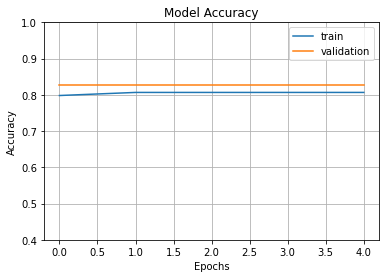

In [66]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

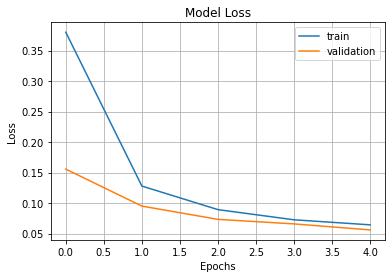

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [68]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [69]:
predictions = model.predict(
      x=x_cross_validation
    , batch_size=10
    , verbose=0
) 

In [70]:
y_truth = y_cross_validation

In [71]:
for i in predictions :
   print(i)

[0.27849025]
[0.27849984]
[0.27848256]
[0.28070652]
[0.2782615]
[0.27838635]
[0.279369]
[0.2811876]
[0.27950293]
[0.27849472]
[0.2784335]
[0.27856737]
[0.27912268]
[0.27895615]
[0.27834645]
[0.27898544]
[0.27933103]
[0.27964512]
[0.27884895]
[0.278345]
[0.27862945]
[0.27831826]
[0.2784289]
[0.2784176]
[0.27839595]
[0.27886415]
[0.27830896]
[0.2786615]
[0.27895942]
[0.27862304]
[0.2785017]
[0.27862495]
[0.27850494]
[0.27841318]
[0.28015417]
[0.2785123]
[0.27841926]
[0.2789434]
[0.278446]
[0.2792595]
[0.2783784]
[0.27865204]
[0.2785319]
[0.27956063]
[0.2784603]
[0.2780503]
[0.27902094]
[0.2783902]
[0.27818727]
[0.27851948]
[0.27850392]
[0.27828166]
[0.27867216]
[0.27858365]
[0.27827892]
[0.27873102]
[0.27869505]
[0.2783953]
[0.27813163]
[0.27828395]
[0.27850905]
[0.27843702]
[0.27842036]
[0.27891138]
[0.27841416]
[0.27953863]
[0.27839658]
[0.27841997]
[0.27869925]
[0.2805487]
[0.27836388]
[0.2823353]
[0.2837046]
[0.27843446]
[0.27870893]
[0.27827018]
[0.27872622]
[0.27875587]
[0.27828172

In [72]:
rounded_predictions = np.argmax(predictions, axis=-1)

for i in rounded_predictions:
    print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [73]:
cm = confusion_matrix(y_true=y_truth, y_pred=rounded_predictions)

In [74]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [75]:
cm_plot_labels = ['Benign','melanoma']

Confusion matrix, without normalization
[[510   0]
 [107   0]]


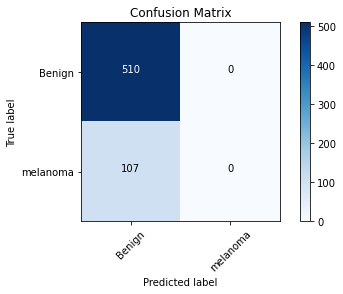

In [76]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [77]:
from tensorflow.keras.models import load_model
import cv2

model.save('2020_resnet.h5')






In [78]:
from keras.models import load_model



load_status = keras.models.load_model("2020_resnet.h5",custom_objects ={'focal_crossentropy':focal_loss()})

In [79]:
inp = r"./ISIC_2020_Training_JPEG/train/ISIC_0052212.jpg"
import cv2

img=cv2.imread(inp)

print(img)
image=cv2.imread(inp)
image_resized= cv2.resize(image, (224,224))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)


[[[139 118 186]
  [142 121 189]
  [147 126 194]
  ...
  [130 113 164]
  [131 114 165]
  [131 114 165]]

 [[145 124 192]
  [148 127 195]
  [151 130 198]
  ...
  [131 114 165]
  [132 115 166]
  [132 115 166]]

 [[146 125 193]
  [148 127 195]
  [149 128 196]
  ...
  [133 116 167]
  [133 116 167]
  [133 116 167]]

 ...

 [[113 104 161]
  [113 104 161]
  [112 103 160]
  ...
  [ 85  72 116]
  [ 85  72 116]
  [ 85  72 116]]

 [[114 105 162]
  [114 105 162]
  [113 104 161]
  ...
  [ 85  72 116]
  [ 84  72 114]
  [ 84  72 114]]

 [[118 106 164]
  [117 105 163]
  [117 105 163]
  ...
  [ 84  72 114]
  [ 84  72 114]
  [ 84  72 114]]]
(1, 224, 224, 3)


In [80]:
nfkej = load_status.predict(image)
print(nfkej)

1/1 [==============================] - 1s 732ms/step
[[0.37613428]]
